In [1]:
from IPython.display import Image

### 1. Using quantum computers to simulate financial markets

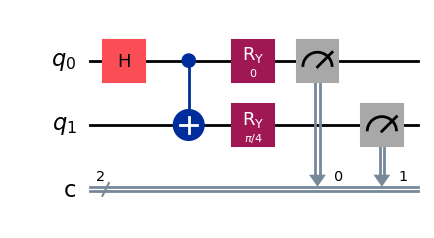

In [2]:
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
from qiskit.visualization import plot_histogram
import numpy as np

# 创建 CHSH 量子电路
qc = QuantumCircuit(2, 2)

# 生成 Bell 态
qc.h(0)  # 量子比特 0 进入叠加态
qc.cx(0, 1)  # 量子比特 1 与 0 纠缠

# 选择测量角度（模拟市场波动）
theta_A1 = 0
theta_A2 = np.pi / 4
theta_B1 = np.pi / 8
theta_B2 = 3 * np.pi / 8

# 测量 A1, B1
qc.ry(2 * theta_A1, 0)
qc.ry(2 * theta_B1, 1)
qc.measure([0,1], [0,1])

qc.draw("mpl")

Measured 00 with frequency 0.4169921875
Measured 10 with frequency 0.0673828125
Measured 01 with frequency 0.0810546875
Measured 11 with frequency 0.4345703125


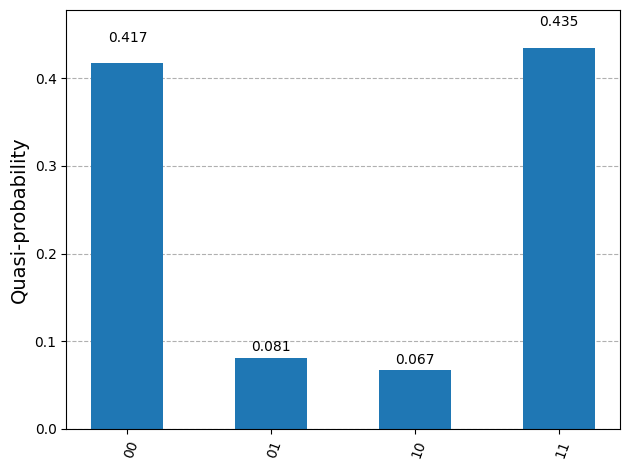

In [3]:
# Running a quantum computer simulator
result = Sampler().run(qc).result()
statistics = result.quasi_dists[0].binary_probabilities()

for outcome, frequency in statistics.items():
    print(f"Measured {outcome} with frequency {frequency}")

display(plot_histogram(statistics))

# 2. CHSH price rise and fall prediction

In [6]:
import numpy as np
import pandas as pd
import yfinance as yf
from qiskit_aer.primitives import Sampler
#from qiskit_machine_learning.algorithms import VQC
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
import random
from math import pi

In [7]:
def chsh_game(strategy, x, y):
    """Plays the CHSH game
    Args:
        strategy (callable): A function that takes two bits (as `int`s) and
            returns two bits (also as `int`s). The strategy must follow the
            rules of the CHSH game.
    Returns:
        int: 1 for a win, 0 for a loss.
    """
    # Referee chooses x and y randomly
    #x, y = np.random.randint(0, 2), np.random.randint(0, 2)

    # Use strategy to choose a and b
    a, b = strategy(x, y)

    # Referee decides if Alice and Bob win or lose
    if (a != b) == (x & y):
        return 1  # Win
    return 0  # Lose

def chsh_circuit(x, y):
    """Creates a `QuantumCircuit` that implements the best CHSH strategy.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        QuantumCircuit: Circuit that, when run, returns Alice and Bob's
            answer bits.
    """
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.barrier()

    # Alice
    if x == 0:
        qc.ry(0, 0)
    else:
        qc.ry(-pi / 2, 0)
    qc.measure(0, 0)

    # Bob
    if y == 0:
        qc.ry(-pi / 4, 1)
    else:
        qc.ry(pi / 4, 1)
    qc.measure(1, 1)

    return qc

(x,y) = (0,0)


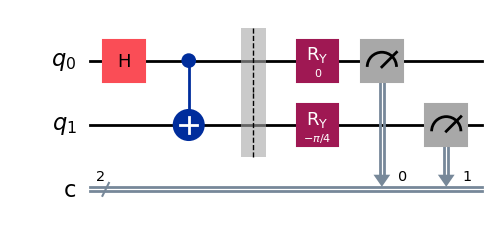

(x,y) = (0,1)


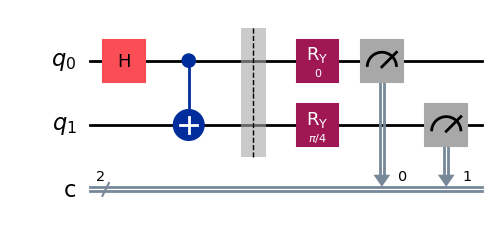

(x,y) = (1,0)


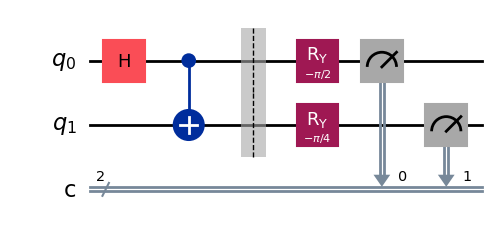

(x,y) = (1,1)


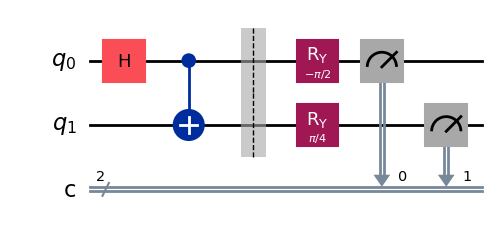

In [8]:
# Draw the four possible circuits

print("(x,y) = (0,0)")
display(chsh_circuit(0, 0).draw("mpl"))

print("(x,y) = (0,1)")
display(chsh_circuit(0, 1).draw("mpl"))

print("(x,y) = (1,0)")
display(chsh_circuit(1, 0).draw("mpl"))

print("(x,y) = (1,1)")
display(chsh_circuit(1, 1).draw("mpl"))

In [9]:
sampler = Sampler()

def quantum_strategy(x, y):
    """Carry out the best strategy for the CHSH game.
    Args:
        x (int): Alice's bit (must be 0 or 1)
        y (int): Bob's bit (must be 0 or 1)
    Returns:
        (int, int): Alice and Bob's answer bits (respectively)
    """
    # `shots=1` runs the circuit once
    result = sampler.run(chsh_circuit(x, y), shots=1).result()
    statistics = result.quasi_dists[0].binary_probabilities()
    bits = list(statistics.keys())[0]
    a, b = bits[0], bits[1]
    return a, b

x, y = 0, 0
quantum_strategy(x, y)

('1', '1')

In [10]:
# 获取股票数据
ticker = "IONQ"
data = yf.download(ticker, start="2025-01-01", end="2025-03-24")["Close"]

# 计算日收益率
returns = data.pct_change().dropna()

# 创建标签（涨 = 1, 跌 = 0）
labels = (returns > 0).astype(int).values
#labels
print(len(labels))
returns.head(2)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

53


Ticker,IONQ
Date,
2025-01-03,0.108353
2025-01-06,0.069081


In [11]:
# （涨 = 1, 跌 = 0）
features = np.column_stack(((returns > 0).astype(int).values[1:], (returns > 0).astype(int).values[:-1]))
len(features), features[:2]

(52,
 array([[1, 1],
        [0, 1]]))

In [12]:
# CHSH预测
predictions = []
TOTAL_SCORE = 0

for i in range(len(features)):
    x,y = features[i][0],features[i][1]
    pred = chsh_game(quantum_strategy,x,y)
    predictions.append(pred)
    
    TOTAL_SCORE += pred

print("Fraction of games won:", TOTAL_SCORE / len(features))

# 计算准确率
true_label = labels[:-1]

# 打印一些预测值与实际值对比
for i in range(5):
    print(f"预测: {predictions[i]}, 实际: {true_label[i]}")

Fraction of games won: 0.8846153846153846
预测: 1, 实际: [1]
预测: 1, 实际: [1]
预测: 1, 实际: [0]
预测: 1, 实际: [0]
预测: 1, 实际: [1]
